<a href="https://colab.research.google.com/github/iampatgrady/Colaboratory-Analytics-Demos/blob/master/Causal_Impact_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Impact Analysis

In [0]:
!pip install pycausalimpact

In [0]:
import numpy as np
import pandas as pd
from causalimpact import CausalImpact
from IPython.display import clear_output

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
#@title Set default project
project_id = "YOUR-PROJECT-HERE" #@param {type:"string"}
from google.cloud.bigquery import magics
magics.context.project = project_id

In [0]:
%%bigquery source
SELECT 
  date,
  SUM(totals.pageviews) AS x1, -- you can add many control series
   -- we'll be faking the y in this example, normally add target here
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_2017*`                  
GROUP BY date
Order by date

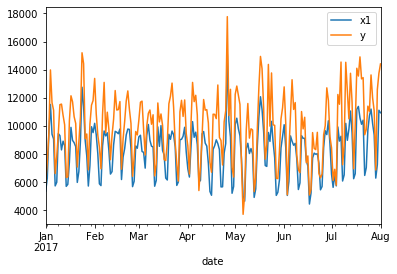

In [40]:
data = source.copy()
data['date']=pd.to_datetime(data['date'])
data.set_index('date',drop=True,inplace=True)
data['y'] = 1.2 * data['x1'] + np.random.normal(size=len(data))*1e3                         # fake your y

pre_period = ['20170101', '20170703']
post_period = ['20170704', '20170801']
interv_len = len(data.loc[data.index >= post_period[0],'y'])

data.loc[data.index >= post_period[0],'y'] += np.abs(np.random.normal(size=interv_len)*1e3) # fake post intervention
_ = data.plot()

In [41]:
ci = CausalImpact(data[['y','x1']],  pre_period , post_period, prior_level_sd=None, n_seasons=7)
clear_output()
print(ci.summary())
# print(ci.summary(output='report'))

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    11556.92           335150.63
Prediction (s.d.)         10683.54 (264.69)  309822.66 (7675.92)
95% CI                    [10170.78, 11208.34][294952.74, 325041.81]

Absolute effect (s.d.)    873.38 (264.69)    25327.97 (7675.92)
95% CI                    [348.58, 1386.13]  [10108.82, 40197.89]

Relative effect (s.d.)    8.17% (2.48%)      8.17% (2.48%)
95% CI                    [3.26%, 12.97%]    [3.26%, 12.97%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))


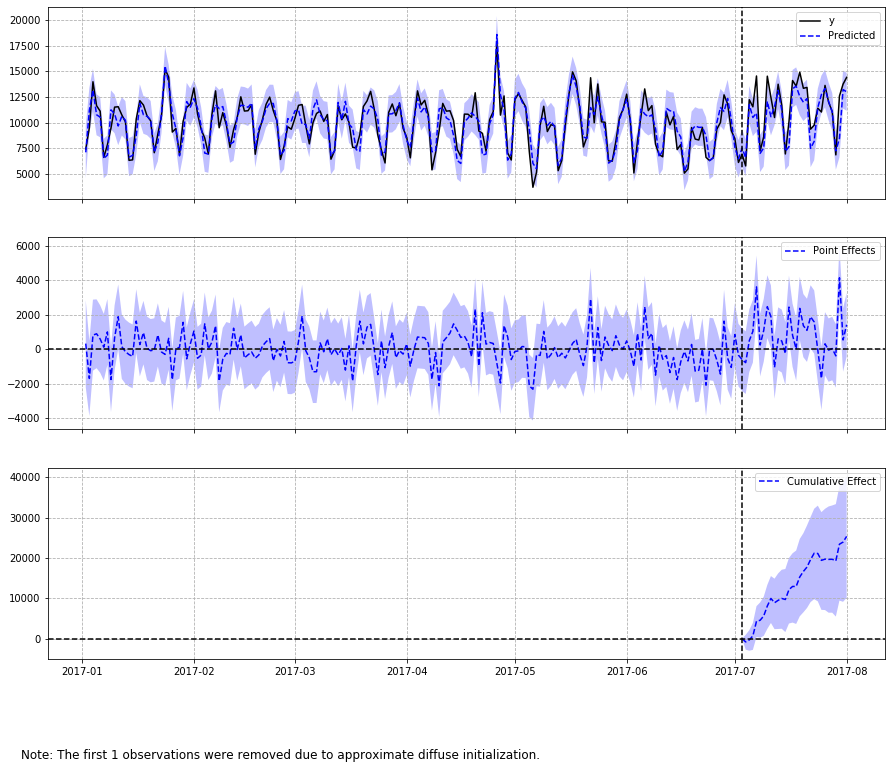

In [42]:
ci.plot()